In [2]:
import os
from pathlib import Path

from modules.analysis import analyze_image_folder
from modules.cleaning import clean_and_resize
from modules.enhancement import apply_clahe, apply_blur
from modules.augmentation import augment_and_save
from modules.utils import is_image_file, save_image

import cv2
from tqdm import tqdm

In [2]:
# Define folders
raw_dibas_folder = "data/raw/dibas"
raw_clinical_folder = "data/raw/clinical-pb"
output_analysis_folder = "data/"

# Create output folder if not exists
Path(output_analysis_folder).mkdir(parents=True, exist_ok=True)

# Analyze raw DIBaS images
analyze_image_folder(raw_dibas_folder, output_analysis_folder)

# Analyze raw Clinical images
analyze_image_folder(raw_clinical_folder, output_analysis_folder)

Total images: 692
Skipping invalid image: data/raw/dibas/Micrococcus.spp_0021.tif
Skipping invalid image: data/raw/dibas/Micrococcus.spp_0023.tif
Skipping invalid image: data/raw/dibas/Listeria.monocytogenes_0023.tif

ANALYSIS: dibas
Total Samples: 689
Mean pixel value: 194.12 ± 16.13
Mean std. deviation: 26.32
Images with very low mean (<30): 0
Images with very high mean (>220): 0
Images with very low std (<10): 60
Images with very high std (>70): 0
Total images: 55

ANALYSIS: clinical-pb
Total Samples: 55
Mean pixel value: 195.95 ± 8.86
Mean std. deviation: 23.48
Images with very low mean (<30): 0
Images with very high mean (>220): 0
Images with very low std (<10): 2
Images with very high std (>70): 2


In [3]:
clean_and_resize("data/raw/dibas", "data/cleaned/dibas")
clean_and_resize("data/raw/clinical-pb", "data/cleaned/clinical-pb")

In [4]:
import json
import cv2
import matplotlib.pyplot as plt
import shutil

metadata_path = Path("data/results/analysis/clinical-pb/image_metadata.json")
image_root = Path("data/raw/clinical-pb")
output_dir = Path("data/processed/clinical-pb")
output_dir.mkdir(parents=True, exist_ok=True)

MIN_ENTROPY = 4.0
MIN_LAPLACIAN_VAR = 20.0

In [5]:
with open(metadata_path) as f:
    metadata = json.load(f)

In [6]:
filtered = [m for m in metadata if m["entropy"] < MIN_ENTROPY or m["laplacian_var"] < MIN_LAPLACIAN_VAR]
print(f"Selected {len(filtered)} out of {len(metadata)} images for enhancement")
selected_files = set(entry["file"] for entry in filtered)

Selected 31 out of 55 images for enhancement


In [7]:
from concurrent.futures import ThreadPoolExecutor

def process_image(entry, selected_files, image_root, output_dir, min_entropy, min_laplacian_var):
    img_path = Path(entry["file"]).resolve()
    rel_path = os.path.relpath(img_path, image_root.resolve())
    out_path = output_dir / rel_path
    out_path.parent.mkdir(parents=True, exist_ok=True)
    enhanced = False
    moved = False

    if entry["file"] in selected_files:
        img = cv2.imread(str(img_path))
        if img is not None:
            enhanced_img = apply_clahe(img)
            enhanced_img = apply_blur(enhanced_img, method='gaussian')
            if cv2.imwrite(str(out_path), enhanced_img):
                enhanced = True
    else:
        try:
            shutil.copy2(str(img_path), str(out_path))
            moved = True
        except Exception:
            pass
    return enhanced, moved

# Prepare arguments
args = [
    (entry, selected_files, image_root, output_dir, MIN_ENTROPY, MIN_LAPLACIAN_VAR)
    for entry in metadata
]

# Run in parallel
enhanced_count = 0
moved_count = 0
with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda p: process_image(*p), args))
    for enhanced, moved in results:
        if enhanced:
            enhanced_count += 1
        if moved:
            moved_count += 1

print(f"Enhanced images: {enhanced_count}")
print(f"Moved images: {moved_count}")

Enhanced images: 31
Moved images: 24


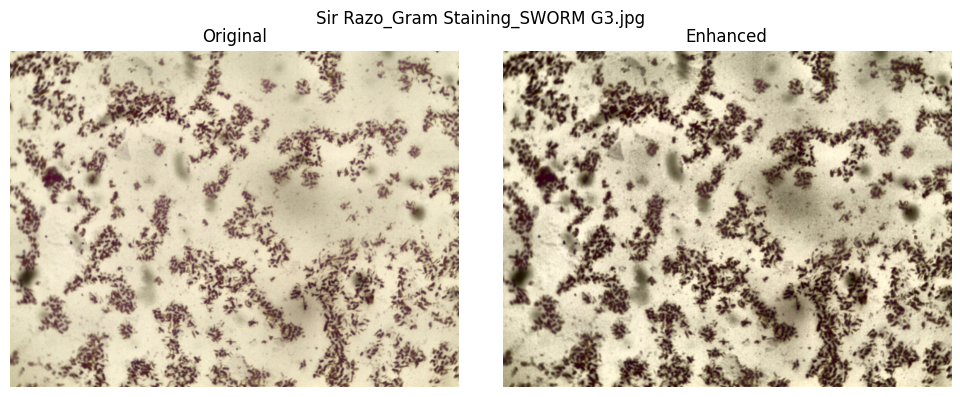

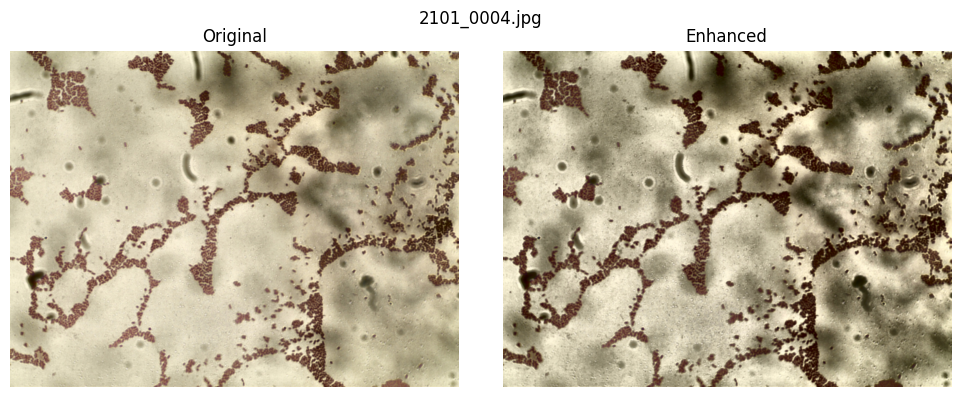

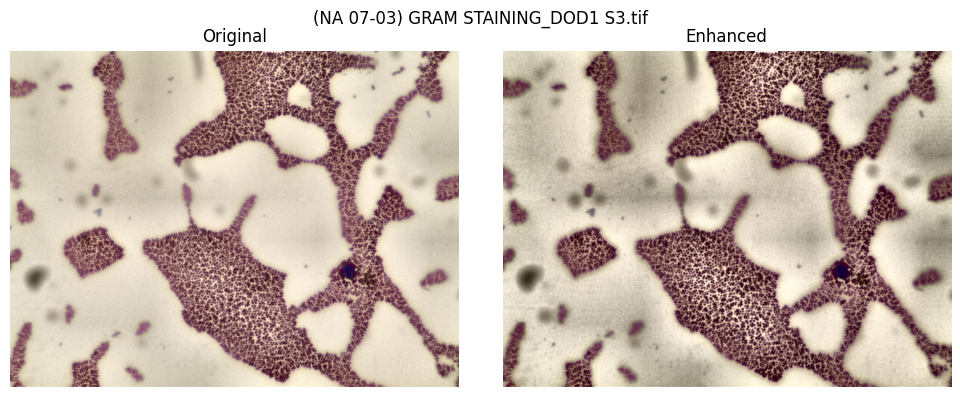

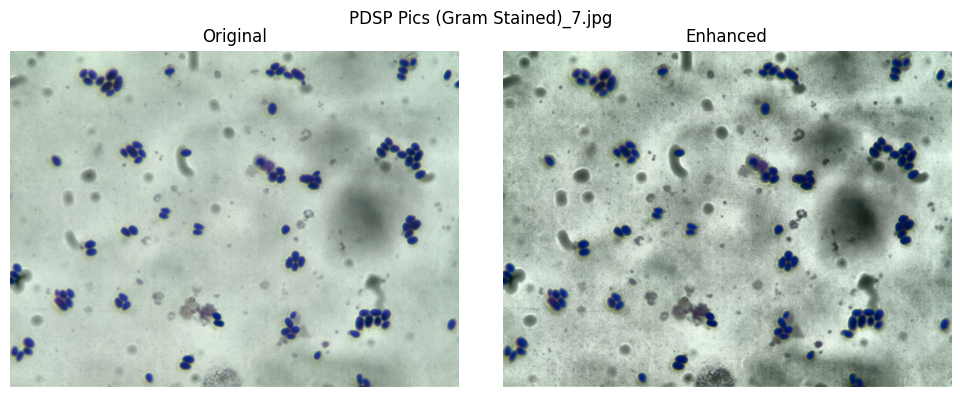

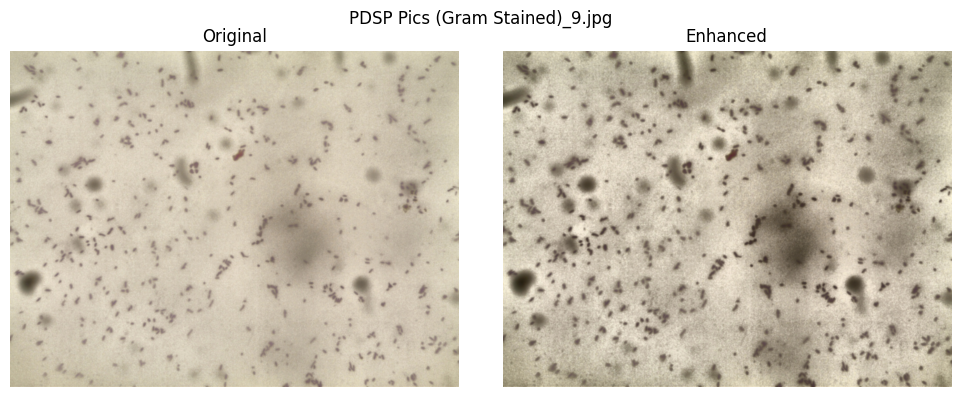

In [8]:
num_show = min(5, len(filtered))
for i in range(num_show):
    entry = filtered[i]
    img_path = Path(entry["file"])
    original = cv2.imread(str(img_path))
    enhanced = apply_blur(apply_clahe(original), method='gaussian')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Enhanced")
    axes[1].axis("off")
    plt.suptitle(Path(entry["file"]).name)
    plt.tight_layout()
    plt.show()


In [9]:
# Define folders
processed_dibas_folder = "data/processed/dibas"
processed_clinical_folder = "data/processed/clinical-pb"
output_analysis_folder = "data/"

# Create output folder if not exists
Path(output_analysis_folder).mkdir(parents=True, exist_ok=True)

# Analyze raw DIBaS images
# analyze_image_folder(processed_dibas_folder, output_analysis_folder)

# Analyze raw Clinical images
analyze_image_folder(processed_clinical_folder, output_analysis_folder)

Total images: 55



ANALYSIS: clinical-pb
Total Samples: 55
Mean pixel value: 169.29 ± 11.23
Mean std. deviation: 54.70
Images with very low mean (<30): 0
Images with very high mean (>220): 0
Images with very low std (<10): 0
Images with very high std (>70): 5


In [10]:
augment_and_save("data/processed/dibas", "data/augmented/dibas")

In [11]:
analyze_image_folder("data/augmented/dibas", "data/")

Total images: 4134

ANALYSIS: dibas
Total Samples: 4134
Mean pixel value: 171.89 ± 26.64
Mean std. deviation: 53.70
Images with very low mean (<30): 0
Images with very high mean (>220): 0
Images with very low std (<10): 17
Images with very high std (>70): 1368


In [1]:
from pathlib import Path
from modules.split_data import split_dataset, move_clinical_to_test

dibas_path = Path("data/augmented/dibas")
clinical_path = Path("data/processed/clinical-pb")
split_output = Path("data/splits")

split_dataset(
    source_dir=dibas_path,
    output_dir=split_output,
    train_ratio=0.8,
    resize=True,
    size=(224, 224)
)

move_clinical_to_test(
    source_dir=clinical_path,
    output_dir=split_output,
    resize=True,
    size=(224, 224)
)


Split complete: 3307 train, 827 val
Moved 55 images to test set.
